<a href="https://colab.research.google.com/github/Cado87/detr-resnet-50/blob/main/DETR_Resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import time # Import the time module

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")

# Measure inference time
start_time = time.time()
outputs = model(**inputs)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.4f} seconds")

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Inference time: 3.4959 seconds
Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


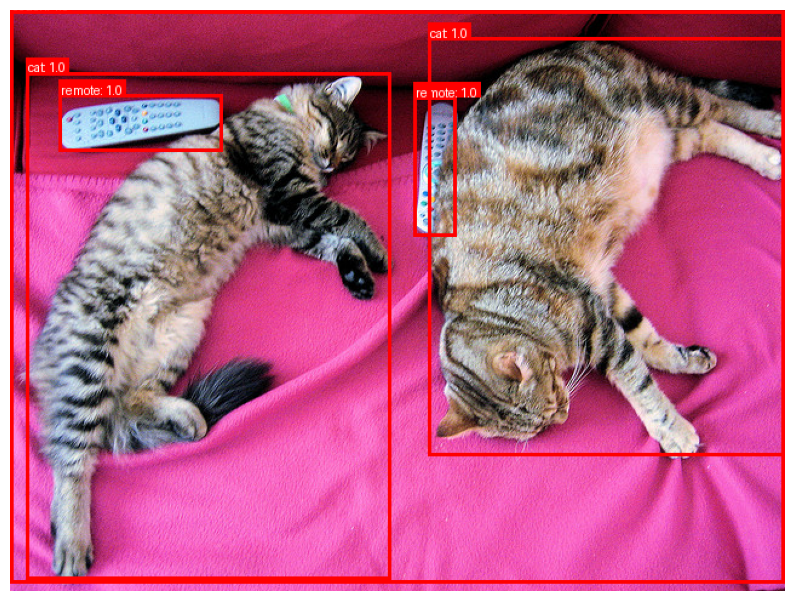

In [2]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

# Make a copy of the image to draw on
draw_image = image.copy()
draw = ImageDraw.Draw(draw_image)

# You might need to install Pillow's ImageFont if you don't have it
# or specify a default font if you don't want to use truetype
try:
    font = ImageFont.truetype("arial.ttf", 18)
except IOError:
    font = ImageFont.load_default()

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x_min, y_min, x_max, y_max = box

    # Draw the bounding box
    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

    # Get the label name
    label_name = model.config.id2label[label.item()]
    text_to_display = f"{label_name}: {round(score.item(), 2)}"

    # Calculate text width and height using textbbox
    # The textbbox method returns (left, top, right, bottom) relative to the anchor (0,0) for size calculation
    left, top, right, bottom = draw.textbbox((0, 0), text_to_display, font=font)
    text_width = right - left
    text_height = bottom - top

    # Define the position for the text background rectangle
    # We want the bottom of the text background to align with y_min
    # And provide some padding
    text_bg_x1 = x_min
    text_bg_y1 = y_min - text_height - 4 # 4 pixels padding above text
    text_bg_x2 = x_min + text_width + 4 # 4 pixels padding to the right
    text_bg_y2 = y_min # Align with the top of the bounding box

    draw.rectangle([text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2], fill="red")

    # Define the position for the text itself
    text_x = x_min + 2 # 2 pixels padding from the left edge of the background
    text_y = y_min - text_height - 2 # 2 pixels padding from the top edge of the background

    draw.text((text_x, text_y), text_to_display, fill="white", font=font)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(draw_image)
plt.axis('off')
plt.show()